In [87]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import psycopg2;

In [40]:
conn = psycopg2.connect(dbname='COMPG011', host='127.0.0.1', user='postgres', password='password')
cur = conn.cursor()

## Removing Outliers

In [44]:
# Perform a query with logic to remove outliers
# People with more headshots than total kills,
# more than 9 kills per round,
# and more than 4,000,000 headshots are removed (3946 total)
# This is an average of 5 kills in a 2 minute game * 12 hours/day * 365 days/year * 6 years

clipping_condition = '''a.total_kills / 9 <= b.total_rounds
                        AND a.total_kills_headshot <= a.total_kills
                        AND a.total_kills_headshot < 4000000'''

cur.execute('''SELECT a.user_id, a.total_kills_headshot
                FROM csgo.profiles a, 
                    (SELECT user_id, sum(total_rounds) AS total_rounds 
                    FROM csgo.maps_stats
                    GROUP BY user_id) b
                WHERE a.user_id = b.user_id
                AND a.total_kills_headshot IS NOT NULL
                AND %s''' %clipping_condition)

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]

df = pd.DataFrame(rows, columns = col_names)
headshots = np.flip(np.sort(df['total_kills_headshot']), axis=0)

In [45]:
cur.execute('''SELECT a.user_id, a.total_kills_headshot
                FROM csgo.profiles a, 
                    (SELECT user_id, sum(total_rounds) AS total_rounds 
                    FROM csgo.maps_stats
                    GROUP BY user_id) b
                WHERE a.user_id = b.user_id
                AND a.total_kills_headshot IS NOT NULL
                AND NOT (%s)''' %clipping_condition)

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]

df = pd.DataFrame(rows, columns = col_names)
headshots_excluded = np.flip(np.sort(df['total_kills_headshot']), axis=0)

## Calculate moments
### Jacknife
`c` is the number of splits created in the dataset. 10 is recommended by the slides.

In [10]:
c = 10
arrays = np.array_split(np.random.permutation(headshots), c)
indices = np.arange(c)

means = []
variances = []
skews = []
kurtoses = []

for i in indices:
    l_prime = np.concatenate([arrays[j] for j in indices if j != i])
    
    means.append(np.mean(l_prime))
    variances.append(np.var(l_prime))
    skews.append(scipy.stats.skew(l_prime))
    kurtoses.append(scipy.stats.kurtosis(l_prime))

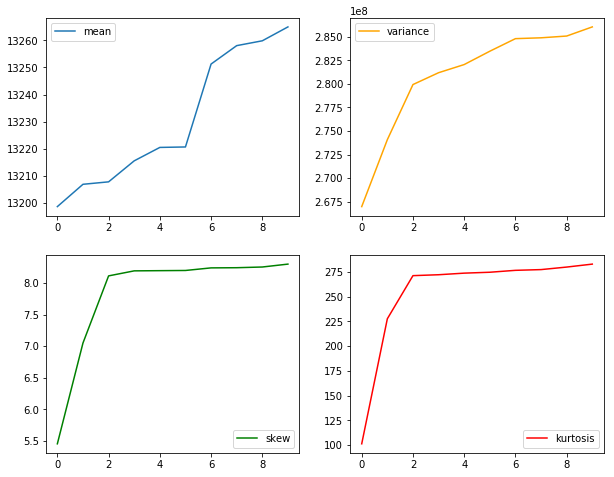

In [11]:
# Setup plot
fig = plt.figure(1, figsize=(10,8))

ax = fig.add_subplot(2, 2, 1, label='plot1')
plt.plot(np.sort(means), label='mean')
plt.legend()

ax = fig.add_subplot(2, 2, 2, label='plot2')
plt.plot(np.sort(variances), color='orange', label='variance')
plt.legend()

ax = fig.add_subplot(2, 2, 3, label='plot3')
plt.plot(np.sort(skews), color='green', label='skew')
plt.legend()


### Bootstrap
`b` is the number of random draws from the dataset.
`m` is the size of the random draws.

In [33]:
b = 10000
m = len(headshots)

means = []
variances = []
skews = []
kurtoses = []

for i in range(b):
    l_prime = np.random.choice(headshots, size=m, replace=True)
    
    means.append(np.mean(l_prime))
    variances.append(np.var(l_prime))
    skews.append(scipy.stats.skew(l_prime))
    kurtoses.append(scipy.stats.kurtosis(l_prime))
    
means = np.sort(means)
variances = np.sort(variances)
skews = np.sort(skews)
kurtoses = np.sort(kurtoses)

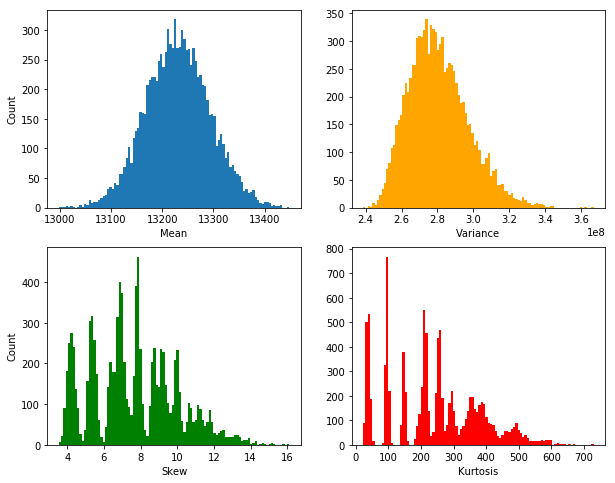

In [96]:
# Setup plot
fig = plt.figure(1, figsize=(10,8))

ax = fig.add_subplot(2, 2, 1, label='plot1')
ax.set_xlabel('Mean')
ax.set_ylabel('Count')
plt.hist(means, bins=100, label='mean')

ax = fig.add_subplot(2, 2, 2, label='plot2')
ax.set_xlabel('Variance')
plt.hist(variances, bins=100, color='orange', label='variance')

ax = fig.add_subplot(2, 2, 3, label='plot3')
ax.set_xlabel('Skew')
ax.set_ylabel('Count')
plt.hist(skews, bins=100, color='green', label='skew')

ax = fig.add_subplot(2, 2, 4, label='plot4')
ax.set_xlabel('Kurtosis')
plt.hist(kurtoses, bins=100, color='red', label='kurtosis')

plt.show()

In [95]:
fig.savefig('jacknife_moments.svg', format='svg', bbox_inches='tight')
plt.close()

In [114]:
mean_conf_inv = (np.percentile(means, 2.5), np.percentile(means, 97.5))
variance_conf_inv = (np.percentile(variances, 2.5), np.percentile(variances, 97.5))
skew_conf_inv = (np.percentile(skews, 2.5), np.percentile(skews, 97.5))
kurtosis_conf_inv = (np.percentile(kurtoses, 2.5), np.percentile(kurtoses, 97.5))

print('Mean confidence interval: %f %f' %mean_conf_inv)
print('Variance confidence interval: %f %f' %variance_conf_inv)
print('Skew confidence interval: %f %f' %skew_conf_inv)
print('Kurtosis confidence interval: %f %f' %kurtosis_conf_inv)

Mean confidence interval: 13109.104007 13353.033442
Variance confidence interval: 253532298.406831 318779361.201410
Skew confidence interval: 4.012231 12.738504
Kurtosis confidence interval: 32.799541 535.055435


### Whole dataset

In [103]:
mean = np.mean(headshots)
median = np.median(headshots)
variance = np.var(headshots)
skew = scipy.stats.skew(headshots)
kurtosis = scipy.stats.kurtosis(headshots)

print('Mean: %s' %mean)
print('Median: %s' %median)
print('Variance: %s' %variance)
print('Skew: %s' %skew)
print('Kurtosis: %s' %kurtosis)

Mean: 13230.4418553
Median: 8401.0
Variance: 280851486.321
Skew: 7.848041037628898
Kurtosis: 255.8391353222861


### Body and tail (separately)

In [99]:
# Body
clip_point = 1495 
body_data = headshots[clip_point:]

mean = np.mean(body_data)
median = np.median(body_data)
variance = np.var(body_data)
skew = scipy.stats.skew(body_data)
kurtosis = scipy.stats.kurtosis(body_data)

print('Body')
print('Mean: %s' %mean)
print('Median: %s' %median)
print('Variance: %s' %variance)
print('Skew: %s' %skew)
print('Kurtosis: %s' %kurtosis)

# Tail
tail_data = headshots[:clip_point]

mean = np.mean(tail_data)
median = np.median(tail_data)
variance = np.var(tail_data)
skew = scipy.stats.skew(tail_data)
kurtosis = scipy.stats.kurtosis(tail_data)

print()
print('Tail')
print('Mean: %s' %mean)
print('Median: %s' %median)
print('Variance: %s' %variance)
print('Skew: %s' %skew)
print('Kurtosis: %s' %kurtosis)

Body
Mean: 11651.7333693
Median: 8150.0
Variance: 123708180.899
Skew: 1.5343154893948503
Kurtosis: 2.2938012313626137

Tail
Mean: 87648.3311037
Median: 75968.0
Variance: 2032838751.5
Skew: 9.170000992698569
Kurtosis: 149.72929111012814


## Plot histogram of data against an exponential distribution

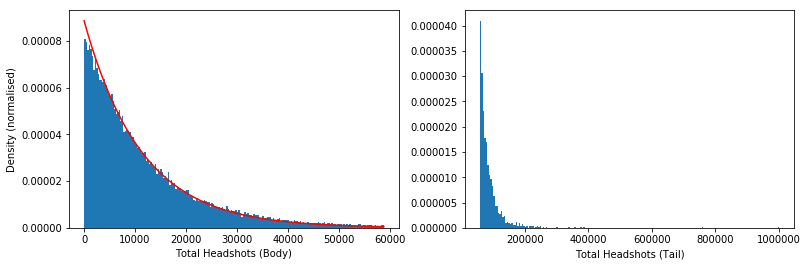

In [83]:
clip_point = 1495
data = headshots[clip_point:]

# Setup plot
fig = plt.figure(1, figsize=(13,4))

# Plot body
ax = fig.add_subplot(1, 2, 1, label='plot5')
ax.set_xlabel('Total Headshots (Body)')
ax.set_ylabel('Density (normalised)')

# Plot histogram
hist, bin_edges = np.histogram(data, bins=200)
plt.hist(data, bins=bin_edges, density=True)

# Plot exponential curve
params = scipy.stats.expon.fit(data)

x_axis = np.linspace(min(data), max(data), 10000)
y_axis = scipy.stats.expon.pdf(x_axis, *params)
plt.plot(x_axis, y_axis, color='red')

# Plot tail
ax = fig.add_subplot(1, 2, 2, label='plot6')
ax.set_xlabel('Total Headshots (Tail)')

data = headshots[:clip_point]

# Plot histogram
hist, bin_edges = np.histogram(data, bins=200)
plt.hist(data, bins=bin_edges, density=True)

# Plot power law
power_law_pdf = lambda b, alpha, x: b * np.power(x, -(alpha + 1))

slope = -3.154488
intercept = 30.835438

x_axis = np.linspace(min(data), max(data), 10000)
y_axis = power_law_pdf(intercept, slope, x_axis)

#plt.plot(x_axis, y_axis, color='red')

plt.show()

## Plot rank-frequency (log-log) of data
The plot is overlaid with a exponential distribution and the tail has been fit with a power law.

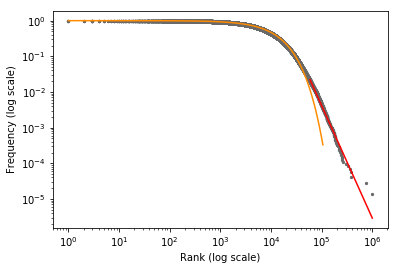

Slope -3.154488, Intercept 30.835438


In [104]:
data_sorted = np.sort(headshots)
rank = np.flip(np.arange(1, len(data_sorted) + 1), axis=0) / (len(data_sorted) + 1)

# Setup plot
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1, label='plot6')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rank (log scale)')
ax.set_ylabel('Frequency (log scale)')

# Plot included points
plt.scatter(data_sorted, rank, s=5, color='dimgrey')

# Plot exponential
params = scipy.stats.expon.fit(data_sorted)
y_axis = scipy.stats.expon.sf(data_sorted, *params)

plt.plot(data_sorted[:-250], y_axis[:-250], color='darkorange')

# Plot tail
clip_start = 1495

lin_data = data_sorted[-clip_start:]
lin_rank = rank[-clip_start:]

slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(np.log(lin_data), np.log(lin_rank))
y_axis = np.log(lin_data) * slope + intercept

plt.plot(lin_data, np.exp(y_axis), color='red')

plt.show()

print('Slope %f, Intercept %f' %(slope, intercept))

In [74]:
fig.savefig('rank_freq_headshots.svg', format='svg', bbox_inches='tight')
plt.close()

## Plot rank-frequency with excluded points

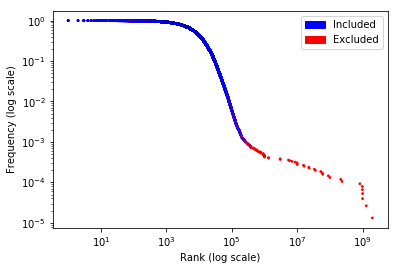

In [105]:
# Setup data
headshots_paired = np.stack((headshots, np.full(len(headshots), 0))).T
headshots_excluded_paired = np.stack((headshots_excluded, np.full(len(headshots_excluded), 1))).T
headshots_merged = np.concatenate([headshots_paired, headshots_excluded_paired])

data_sorted = headshots_merged[headshots_merged[:,0].argsort()]
colors = ['blue' if x == 0 else 'red' for x in data_sorted[:,1]]
rank = np.flip(np.arange(1, data_sorted.shape[0] + 1), axis=0) / (data_sorted.shape[0] + 1)

# Setup plot
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1, label='plot7')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rank (log scale)')
ax.set_ylabel('Frequency (log scale)')

# Plot included points
plt.scatter(data_sorted[:,0], rank, color=colors, s=3)

blue_patch = mpatches.Patch(color='blue', label='Included')
red_patch = mpatches.Patch(color='red', label='Excluded')
plt.legend(handles=[blue_patch, red_patch])

plt.show()

In [91]:
fig.savefig('rank_freq_inc_ex.svg', format='svg', bbox_inches='tight')
plt.close()

## Find the clipping point in between the body and the tail
Utilising the KS test

In [ ]:
data_sorted = np.sort(headshots)

ks_values = []
for clip_count in range(1, 10000):
    clipped_data = data_sorted[:-clip_count]
    
    params = scipy.stats.expon.fit(clipped_data)
    kst = scipy.stats.kstest(clipped_data, 'expon', params)
    
    ks_values.append((clip_count, kst))
        
    if clip_count % 100 == 0:
        print('Finished iteration %i, %s' %(clip_count, kst))

Finished iteration 100, KstestResult(statistic=0.012801234604499334, pvalue=4.0359249689635314e-09)
Finished iteration 200, KstestResult(statistic=0.0096336065385342895, pvalue=2.4252200339804565e-05)
Finished iteration 300, KstestResult(statistic=0.0070099019943682395, pvalue=0.0050378779399443477)
Finished iteration 400, KstestResult(statistic=0.0070636258499622295, pvalue=0.0046408196923223071)
Finished iteration 500, KstestResult(statistic=0.0084973490983818734, pvalue=0.00031253320976215701)
Finished iteration 600, KstestResult(statistic=0.0098503864404648755, pvalue=1.5657292179511938e-05)
Finished iteration 700, KstestResult(statistic=0.01118228175565128, pvalue=5.3870041653960631e-07)
Finished iteration 800, KstestResult(statistic=0.025288100657000989, pvalue=5.7329684270961376e-34)
Finished iteration 900, KstestResult(statistic=0.018373971268642153, pvalue=4.190756255926277e-18)
Finished iteration 1000, KstestResult(statistic=0.014828076230141207, pvalue=6.4036946986673551e-12

Finished iteration 9100, KstestResult(statistic=0.068918843651742612, pvalue=2.5422437823540096e-215)
Finished iteration 9200, KstestResult(statistic=0.069756065979347692, pvalue=3.7589527469553171e-220)
Finished iteration 9300, KstestResult(statistic=0.067533659348734898, pvalue=5.6102729166723657e-206)
Finished iteration 9400, KstestResult(statistic=0.070270442187786664, pvalue=1.5150941415328468e-222)
Finished iteration 9500, KstestResult(statistic=0.070713785605005963, pvalue=6.3557631178992539e-225)
Finished iteration 9600, KstestResult(statistic=0.071152801211386063, pvalue=2.7972841209500724e-227)
Finished iteration 9700, KstestResult(statistic=0.071587634214492324, pvalue=1.2902333081551877e-229)
Finished iteration 9800, KstestResult(statistic=0.072017059046937948, pvalue=6.3573099157775132e-232)
Finished iteration 9900, KstestResult(statistic=0.072443949862977197, pvalue=3.2100917541617271e-234)


## Plot the statistics calculated above

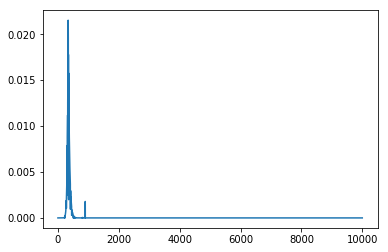

In [254]:
plt.plot(range(1, len(ks_values) + 1), list(map(lambda x: x.pvalue, list(zip(*ks_values))[1])))
plt.show()

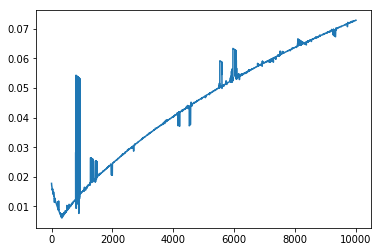

In [256]:
plt.plot(range(1, len(ks_values) + 1), list(map(lambda x: x.statistic, list(zip(*ks_values))[1])))
plt.show()

In [107]:
data_sorted = np.sort(headshots)

anderson_values = []
for clip_count in range(1, 10000):
    clipped_data = data_sorted[:-clip_count]

    anderson = scipy.stats.anderson(clipped_data, 'expon')
    
    anderson_values.append((clip_count, anderson))
        
    if clip_count % 100 == 0:
        print('Finished iteration %i, %s' %(clip_count, anderson))

Finished iteration 100, AndersonResult(statistic=102.36599281225062, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 200, AndersonResult(statistic=74.041840948630124, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 300, AndersonResult(statistic=54.141496881522471, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 400, AndersonResult(statistic=39.30521632982709, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 500, AndersonResult(statistic=28.093695642281091, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iterati

Finished iteration 4300, AndersonResult(statistic=186.70342129351047, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 4400, AndersonResult(statistic=194.3320505949232, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 4500, AndersonResult(statistic=201.97308591697947, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 4600, AndersonResult(statistic=209.62721426592907, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 4700, AndersonResult(statistic=217.33000850985991, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished it

Finished iteration 8500, AndersonResult(statistic=511.34505776532023, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 8600, AndersonResult(statistic=518.83362592579215, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 8700, AndersonResult(statistic=526.31810146493081, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 8800, AndersonResult(statistic=533.79015907534631, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 8900, AndersonResult(statistic=541.21253829017951, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished i

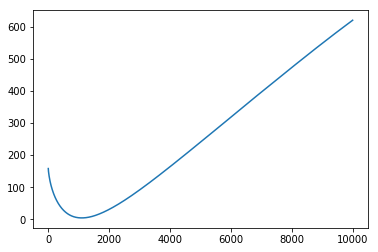

In [108]:
plt.plot(range(1, len(anderson_values) + 1), list(map(lambda x: x.statistic, list(zip(*anderson_values))[1])))
plt.show()

In [259]:
ks_min = sorted(ks_values, key=lambda x: x[1].statistic)[0]
anderson_min = sorted(anderson_values, key=lambda x: x[1].statistic)[0]

print('KS minimum: %i, %f' %(ks_min[0], ks_min[1].statistic))
print('Anderson minimum: %i, %f' %(anderson_min[0], anderson_min[1].statistic))

KS minimum: 338, 0.006102
Anderson minimum: 1, 59.562653


## Show differences in mean and median headshots based on player rank

In [110]:
cur.execute('''SELECT a.id, b.total_kills_headshot FROM csgo.ranks a, csgo.profiles b 
                WHERE a.id = b.rank_id AND 
                        b.total_kills_headshot IS NOT NULL AND
                        b.total_kills_headshot <= b.total_kills
                ORDER BY b.total_kills_headshot DESC''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]

In [113]:
df = pd.DataFrame(rows, columns = col_names)

In [112]:
for i in range(1, 19):
    print("Rank %i: median %f, mean %f" %(i, np.median(df[df.id == i].total_kills_headshot), np.mean(df[df.id == i].total_kills_headshot)))

Rank 1: median 952.000000, mean 2371.569729
Rank 2: median 2240.000000, mean 3067.677348
Rank 3: median 2620.000000, mean 3746.041815
Rank 4: median 2982.000000, mean 18692.984609
Rank 5: median 3437.000000, mean 4449.990172
Rank 6: median 3899.000000, mean 35314.383014
Rank 7: median 4656.500000, mean 5859.850202
Rank 8: median 5487.000000, mean 6933.175837
Rank 9: median 6224.000000, mean 7616.107580
Rank 10: median 7285.000000, mean 9281.824201
Rank 11: median 8781.000000, mean 22555.872724
Rank 12: median 10076.000000, mean 198340.401729
Rank 13: median 11630.000000, mean 208269.876726
Rank 14: median 13300.500000, mean 382442.064652
Rank 15: median 15661.000000, mean 40436.170927
Rank 16: median 18419.000000, mean 307587.264569
Rank 17: median 22041.000000, mean 26348.679380
Rank 18: median 30037.000000, mean 37910.376481
